<a href="https://colab.research.google.com/github/Reffi-ai/2_Classification-of-Dog-and-Cat-Images-in-Google-Colab/blob/main/reffi_pdsk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1: Akses Dataset dari Kaggle

In [ ]:
! nvidia-smi

Thu May 29 10:49:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!mkdir -p ~/.Kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets list -s dog

ref                                                 title                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------  -----------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
tongpython/cat-and-dog                              Cat and Dog                           228487605  2018-04-26 10:56:50.843000         155716       1366  0.75             
danielshanbalico/dog-emotion                        Dog Emotion                           162237964  2023-02-09 09:58:36.820000           5422         62  1.0              
marshuu/dog-breeds                                  Dog breeds                                 3168  2022-12-20 18:49:43.410000           4933         72  1.0              
dansbecker/hot-dog-not-hot-dog                      Hot Dog - Not Hot Dog                  93629064  2018-07-19 05:52:04.077000        

In [ ]:
!kaggle datasets download chetankv/dogs-cats-images

Dataset URL: https://www.kaggle.com/datasets/chetankv/dogs-cats-images
License(s): CC0-1.0
 80% 349M/435M [00:03<00:01, 61.5MB/s]
100% 435M/435M [00:03<00:00, 115MB/s] 


In [ ]:
!unzip "/content/dogs-cats-images.zip"

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/tra

Part 2: Inisialisasi Library

In [ ]:
!pip install livelossplot

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, Input,
    Conv2D, Flatten, MaxPooling2D
)
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from livelossplot.keras import PlotLossesCallback

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import os

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from IPython.display import SVG
from random import randint

Part 3: Pengolahan Dataset

In [ ]:
img_size=128 #semakin kecil gambar proses training akan semakin cepat
             #semakin kecil juga nilai validation accuracy yang didapat

def get_images(directory):
  Images = []
  Labels = []
  label = 0

  for labels in os.listdir(directory):
    if labels == 'dogs':
        label = 0
    elif labels == 'cats':
        label = 1

    for image_file in os.listdir(directory+labels):
        image = cv2.imread(directory+labels+r'/'+image_file)
        image = cv2.resize(image,(img_size,img_size))
        image = image / 255.0
        Images.append(image)
        Labels.append(label)
  return shuffle(Images,Labels,random_state=817328462)

def get_classlabel(class_code):
  labels = {0:'dogs',1:'cats'}

  return labels[class_code]

Images, Labels = get_images("/content/dog vs cat/dataset/training_set/")
Images = np.array(Images)
Labels = np.array(Labels)
print("Ukuran gambar dan jumlah", Images.shape)
print("Labels", Labels.shape)

Ukuran gambar dan jumlah (8000, 128, 128, 3)
Labels (8000,)


Part 4: Membangun Model

In [ ]:
# Gunakan MobileNetV2 sebagai base model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model (bisa di-unfreeze setelah beberapa epoch)

# Tambahkan layer kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # 2 kelas: anjing & kucing

model = Model(inputs=base_model.input, outputs=predictions)

# Lihat ringkasan model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Part 5: Training Model

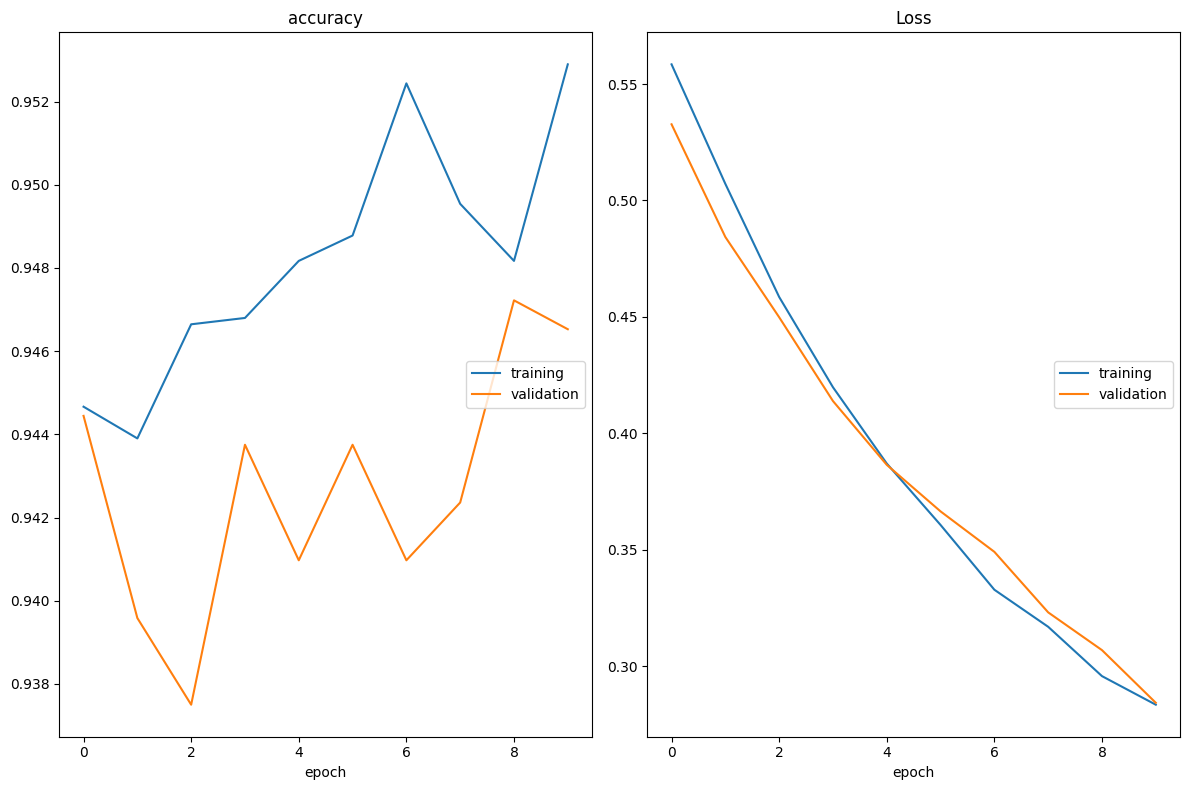

accuracy
	training         	 (min:    0.944, max:    0.953, cur:    0.953)
	validation       	 (min:    0.938, max:    0.947, cur:    0.947)
Loss
	training         	 (min:    0.283, max:    0.558, cur:    0.283)
	validation       	 (min:    0.284, max:    0.533, cur:    0.284)
205/205 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.9521 - loss: 0.2831 - val_accuracy: 0.9465 - val_loss: 0.2842


In [ ]:
# Menyediakan teknik augmentasi gambar seperti rotasi, zoom, flip horizontal, dst., untuk menambah variasi data secara artifisial dan mengurangi overfitting.
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.18
)

# Generator otomatis membagi data menjadi training dan validation.
train_generator = datagen.flow(
    Images, Labels,
    batch_size=32,
    subset='training'
)

val_generator = datagen.flow(
    Images, Labels,
    batch_size=32,
    subset='validation'
)

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Simpan ringkasan model ke file
MODEL_SUMMARY_FILE = "model_summary.txt"
with open(MODEL_SUMMARY_FILE, 'w') as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger("training_logs.csv", append=False, separator=";")

# Training
trained = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[
        PlotLossesCallback(),
        csv_logger,
        early_stop,
        checkpoint
    ]
)

Part 6: Evaluasi dan Visualisasi Prediksi

In [ ]:
test_images, test_labels = get_images("/content/dataset/test_set/")
test_images = np.array(test_images)
test_labels = np.array(test_labels)

model.evaluate(test_images,test_labels, verbose=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9617 - loss: 0.2493


[0.24792417883872986, 0.9629999995231628]

In [ ]:
pred_images, no_labels = get_images("/content/dataset/test_set/")
pred_images = np.array(pred_images)
pred_images.shape

(2000, 128, 128, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

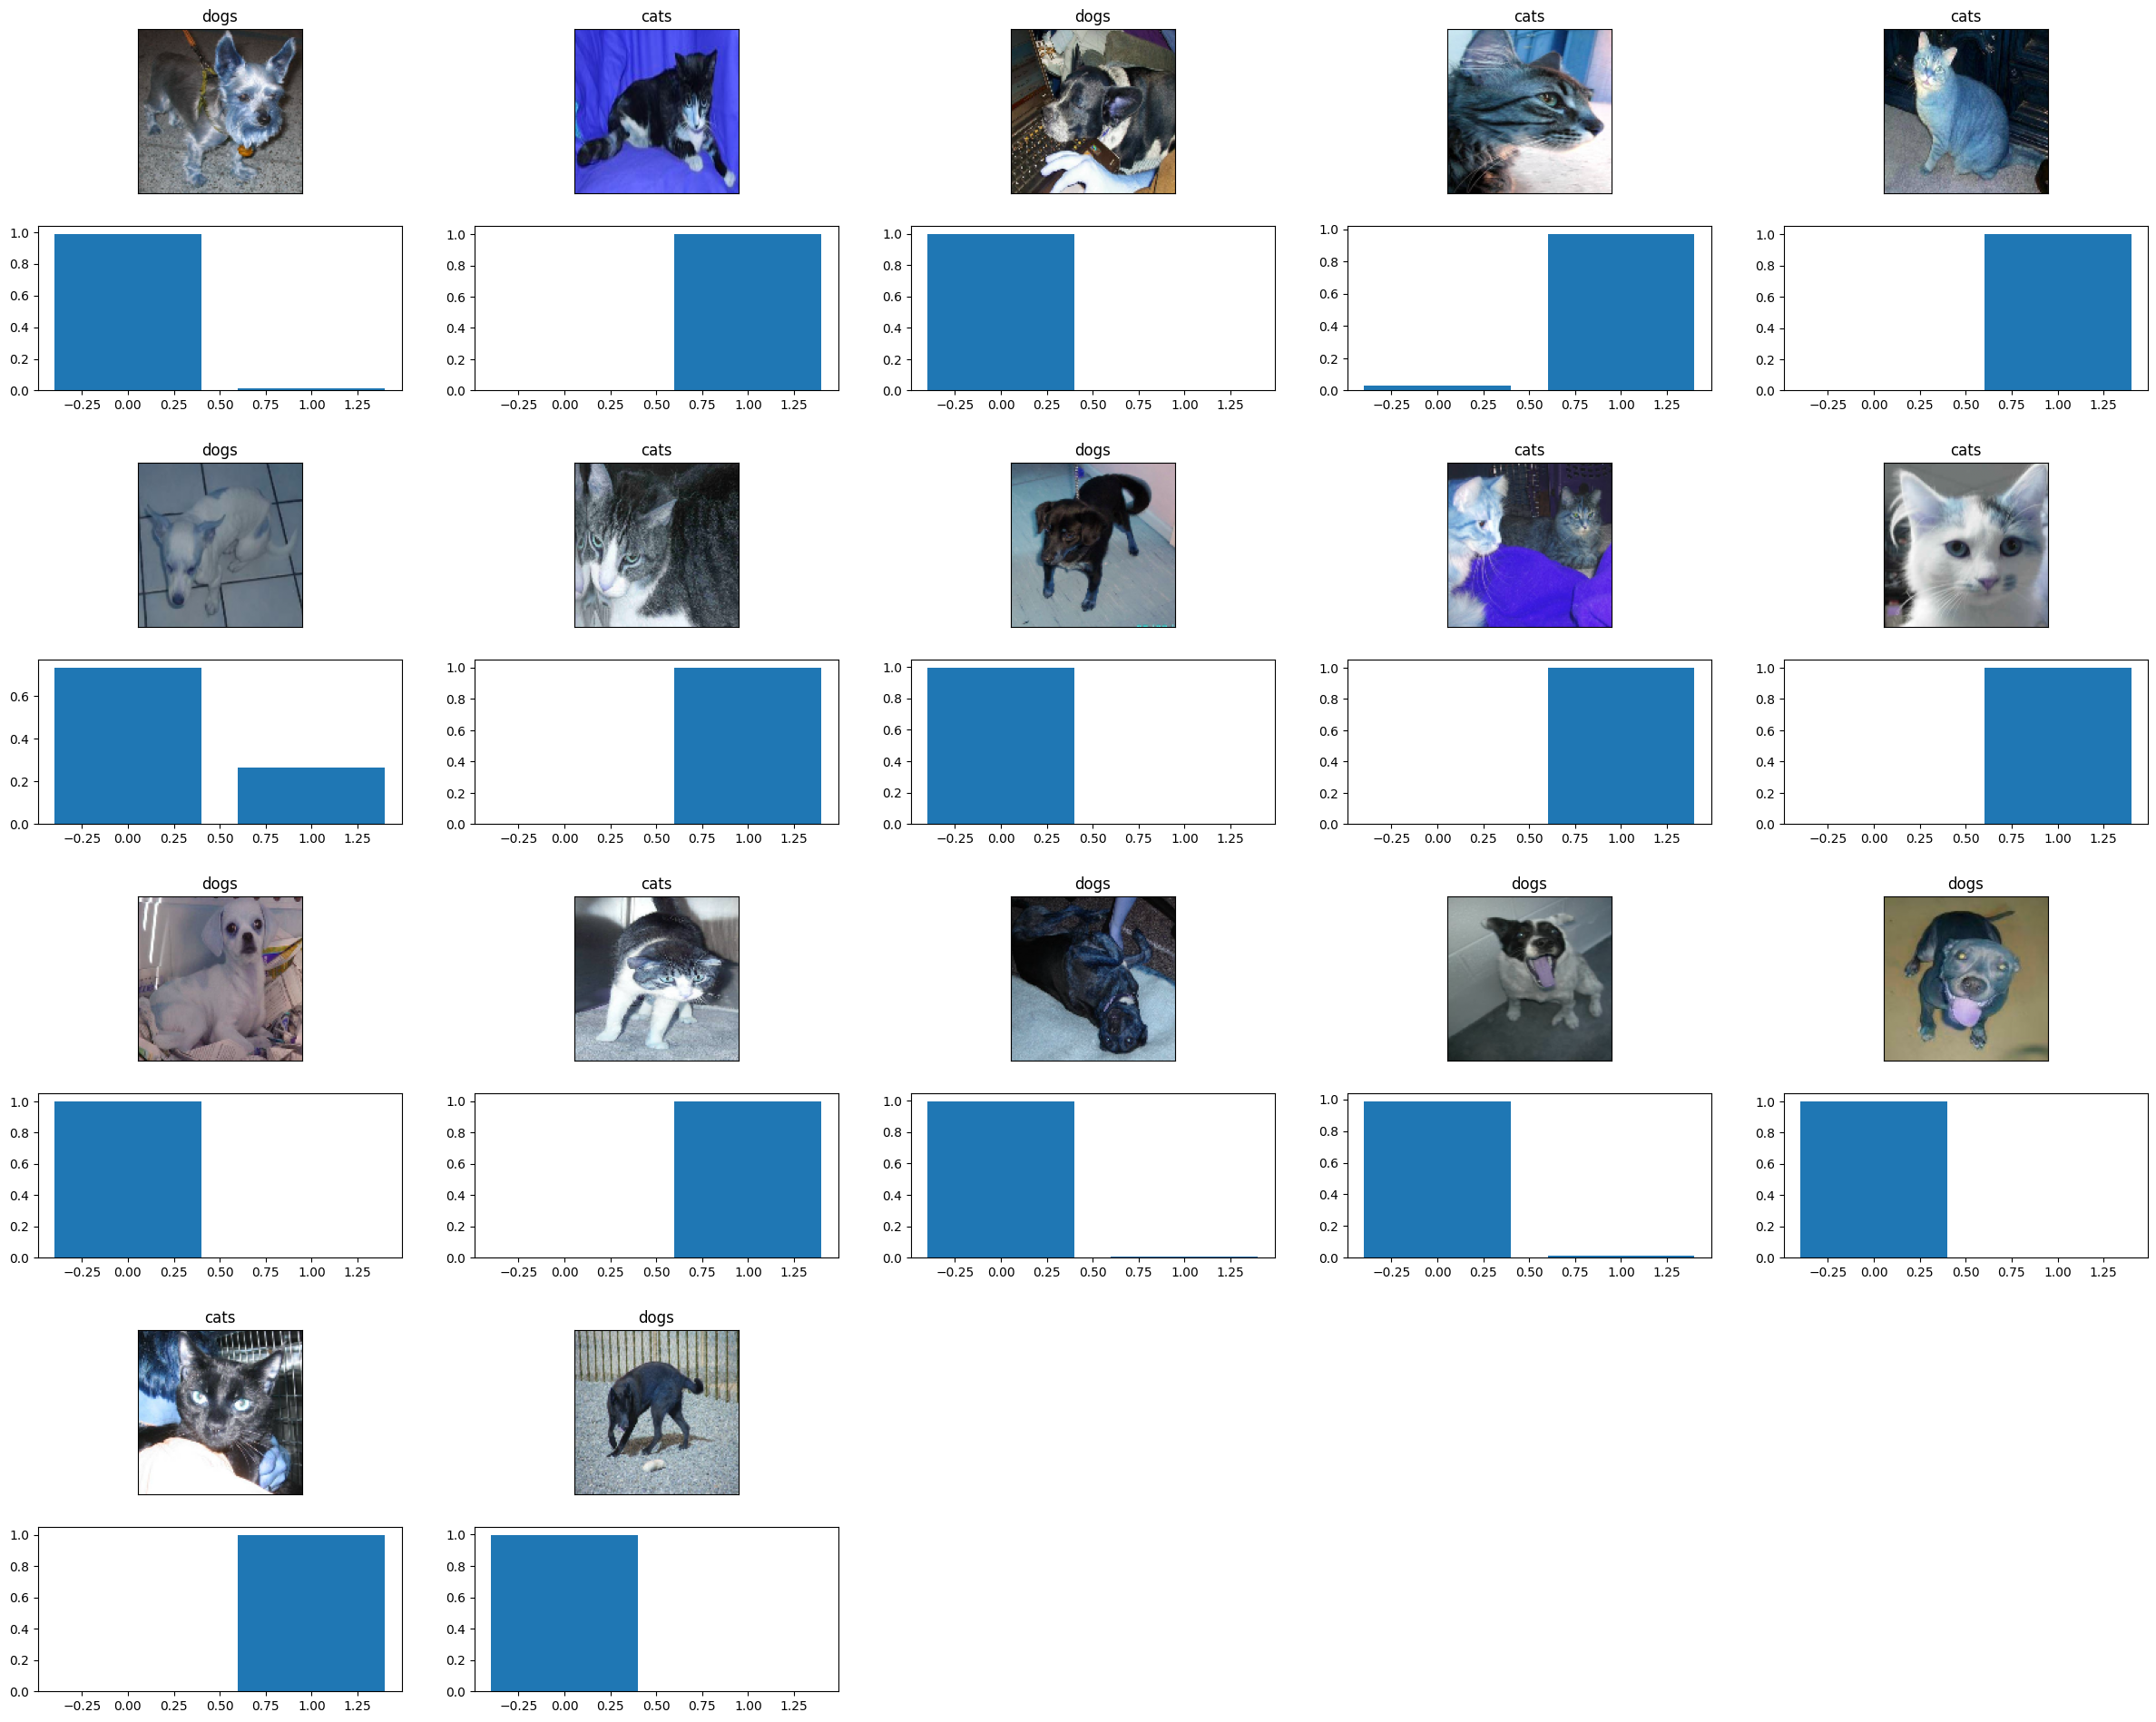

In [ ]:
fig = plt.figure(figsize=(30,30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(17):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], wspace=0.2, hspace=0.2)
    rnd_number = randint(0, len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class_index = np.argmax(model.predict(pred_image), axis=1)[0]
    pred_class = get_classlabel(pred_class_index)
    pred_prob = model.predict(pred_image).reshape(2)

    for j in range(2):
        if (j % 2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0, 1], pred_prob)
            fig.add_subplot(ax)

fig.show()

In [ ]:
!rsync -a --progress "/content/drive/MyDrive/Colab Notebooks/dogs-cats-images.zip" "/content"

sending incremental file list
dogs-cats-images.zip
    455,718,914 100%   92.05MB/s    0:00:04 (xfr#1, to-chk=0/1)


In [ ]:
!unzip "/content/dogs-cats-images.zip"

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/tra

In [ ]:
!rsync -a --progress "/content/drive/MyDrive/Colab Notebooks/kaggle.json" "/content"

sending incremental file list
kaggle.json
             63 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=0/1)


-

In [ ]:
!rsync -a --progress "/content/best_model.keras" "/content/drive/MyDrive/Colab Notebooks/jadi"

sending incremental file list
best_model.keras
     11,590,659 100%   84.79MB/s    0:00:00 (xfr#1, to-chk=0/1)


In [ ]:
!rsync -a --progress "/content/model_summary.txt" "/content/drive/MyDrive/Colab Notebooks/jadi"

sending incremental file list
model_summary.txt
         64,590 100%   30.35MB/s    0:00:00 (xfr#1, to-chk=0/1)


In [ ]:
!rsync -a --progress "/content/training_logs.csv" "/content/drive/MyDrive/Colab Notebooks/jadi"

sending incremental file list
training_logs.csv
            826 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=0/1)
